# scRNA seq analysis

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

In [1]:
bulk = sc.read('/data.h5ad') # annotated data
bulk.var_names_make_unique()
bulk

NameError: name 'sc' is not defined

In [240]:
#removing cells with fewer counts
ad = sc.read('adata.h5ad')
ad

exclude_channels = ad.obs.channel.value_counts() < 30
exclude_channels = exclude_channels[exclude_channels].index

ad = ad[~ad.obs.channel.isin(exclude_channels)]

In [241]:
ad_pseudobulk = ad.copy()

ad_pseudobulk = sc.AnnData(pd.DataFrame(ad_pseudobulk.layers['counts'].A, 
                                        index=ad_pseudobulk.obs.index, 
                                        columns=ad_pseudobulk.var_names).groupby(ad_pseudobulk.obs.channel).mean(0))
ad_pseudobulk.obs.index.name = None

ad_pseudobulk.obs = ad_pseudobulk.obs.join(ad.obs[['channel', 'tissue', 'prep', 'Tissue', 'Sample ID', 'Participant ID', 'Age']].drop_duplicates().set_index('channel'))
ad_pseudobulk.obs['Tissue detail'] = ad_pseudobulk.obs.Tissue

bulk.obs.rename(columns={'SMTS': 'Tissue', 'SMTSD': 'Tissue detail'}, inplace=True)
bulk.obs['Sample ID'] = bulk.obs.index

#bulk.obs = bulk.obs[['Sample ID', 'Tissue', 'Tissue detail']]
bulk.obs['Participant ID'] = ['-'.join(x.split('-')[:2]) for x in bulk.obs['Sample ID']]
bulk.obs['prep'] = 'bulk'

adata = sc.concat([bulk, ad_pseudobulk], label='bulk-pseudobulk', keys=['bulk', 'pseudobulk'])
adata.X = sp.sparse.csr_matrix(adata.X)

/home/gokcen/.miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.


In [242]:
adata

AnnData object with n_obs × n_vars = 17472 × 17058
    obs: 'Tissue', 'Tissue detail', 'Sample ID', 'Participant ID', 'prep', 'bulk-pseudobulk'

In [13]:
ad = ad[:, adata.var_names].copy()
bulk = bulk[:, adata.var_names].copy()

In [14]:
ad_pseudobulk.X

array([[0.41591927, 0.00112108, 0.05941704, ..., 0.08295964, 0.00224215,
        0.1647982 ],
       [0.65816325, 0.01020408, 0.05102041, ..., 0.12244898, 0.        ,
        0.11734694],
       [0.16544738, 0.00619021, 0.03151379, ..., 0.08216094, 0.00168824,
        0.10748453],
       ...,
       [0.28869778, 0.002457  , 0.0534398 , ..., 0.13144962, 0.00307125,
        0.14864865],
       [0.0945946 , 0.        , 0.04054054, ..., 0.08108108, 0.        ,
        0.02702703],
       [0.17742531, 0.00184434, 0.0398377 , ..., 0.12578385, 0.00184434,
        0.1910734 ]], dtype=float32)

In [15]:
ad.X.data

array([0.70614594, 0.70614594, 1.8133311 , ..., 3.2556958 , 3.2556958 ,
       3.2556958 ], dtype=float32)

In [16]:
bulk.X.data

array([3.598e-01, 9.074e+01, 1.086e+01, ..., 5.314e-03, 4.688e-02,
       2.141e-02], dtype=float32)

In [17]:
adata.X.data

array([0.03055   , 0.2788    , 0.02275   , ..., 0.01143489, 0.0398377 ,
       0.00184434], dtype=float32)

In [18]:
sample2x = adata.obs[['Tissue', 'prep']].reset_index().drop_duplicates().set_index('index').to_dict()

In [19]:
def preprocess(top_genes=2000, normalize=True, scale=True, npcs=50, nneighbors=10, metric='euclidean', harmon=True):

    sc.pp.highly_variable_genes(ad, n_top_genes=top_genes, flavor='seurat_v3', layer='counts')

    adata_sub = adata[:, ad.var.highly_variable].copy()
    
    if normalize:
        sc.pp.normalize_total(adata_sub, target_sum=10000)
    sc.pp.log1p(adata_sub)
    if scale:
        sc.pp.scale(adata_sub, max_value=10)
    sc.pp.pca(adata_sub, n_comps=npcs)

    from harmony import harmonize

    if harmon:
        adata_sub.obsm['X_harmony'] = harmonize(adata_sub.obsm['X_pca'], adata_sub.obs, ['bulk-pseudobulk'], max_iter_harmony=20)
        rep = 'X_harmony'
    else:
        rep = None
        
    sc.pp.neighbors(adata_sub, n_neighbors=nneighbors, use_rep=rep, metric=metric)
    #sc.tl.umap(adata_sub)
    
    return adata_sub

## Fraction of nearest neighbors

In [20]:
def accuracy_dfs(ads, sample2x):

    cell_idx_pb, cell_idx_b = ads.obsp['distances'][ads.obs['bulk-pseudobulk']=='pseudobulk'].nonzero()

    pb = ads[ads.obs['bulk-pseudobulk'] == 'pseudobulk'][cell_idx_pb].obs.copy()
    b = ads[cell_idx_b].obs.copy()
    
    pb = pb[(b.prep=='bulk').values].copy()
    b = b[b.prep=='bulk'].copy()
    
    if pb.index.nunique() != ad.obs.channel.nunique():
        print('!!')
        return None, 0
    
    tissue_pb2b = {'Skeletal muscle': 'Muscle', 'Esophagus muscularis': 'Esophagus', 'Esophagus mucosa': 'Esophagus'}

    pb['bulk_translated'] = [tissue_pb2b.get(x,x) for x in pb.Tissue]
    pb['predicted'] = b.Tissue.values
    pb['match'] = pb.bulk_translated == pb.predicted

    acc = pb.groupby(['Sample ID', 'prep'], observed=True)['match'].mean().reset_index().match.mean()*100

    props = []

    for s in pb.index.unique():
        df = b.loc[(pb.index == s)]
        df.Tissue = pd.Categorical(df.Tissue, categories=bulk.obs.Tissue.cat.categories)
        df = df.Tissue.value_counts(normalize=True).reset_index().assign(sample=s, orig_tissue=sample2x['Tissue'][s], prep=sample2x['prep'][s])
        props.append(df)

    props = pd.concat(props, axis=0)
    props['index'] = pd.Categorical(props['index'], categories=bulk.obs.Tissue.cat.categories[::-1])

    #display(props[props.Tissue>0])
    props.Tissue.loc[props.Tissue==0] = np.nan
    
    return props, acc

## hyperopt

In [ ]:
from hyperopt import hp

space = {
    'metric': hp.choice('metric', ['euclidean', 'correlation', 'cosine', 'l1']),
    'top_genes': hp.uniform('top_genes', 100, 5000),
    'npcs': hp.uniform('npcs', 10, 1000),
    'nneighbors': hp.uniform('nneighbors', 5, 100),
    'normalize': hp.choice('normalize', [True, False]),
    'scale': hp.choice('scale', [True, False]),
    'harmon': hp.choice('harmon', [True, False]),
}

space = {
    'top_genes': hp.uniform('top_genes', 100, 5000),
    'npcs': hp.uniform('npcs', 10, 1000),
    'nneighbors': hp.uniform('nneighbors', 5, 100),
}


def objective(x):
    try:
        x = preprocess(
            top_genes=round(x['top_genes']),
            metric='l1',
            npcs=round(x['npcs']),
            nneighbors=round(x['nneighbors']),
            scale=False,
            normalize=True,
            harmon=True,        
        )
        df, acc = accuracy_dfs(x, sample2x)
        
    except:
        return np.nan
    
    return 100-acc
                  
# minimize the objective over the space
from hyperopt import fmin, tpe, space_eval, Trials

trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, max_evals=200, trials=trials)

print(best)

In [35]:
res = pd.concat([pd.DataFrame(trials.vals), pd.DataFrame(trials.results)], axis=1)
res.sort_values('loss').head(20)

nneighbors        npcs    top_genes       loss status
184   47.472317   69.545643  3522.478603   7.629766     ok
140   75.979911  251.912942  3743.830444  10.551162     ok
82    90.604395  124.812702  1290.516463  10.945633     ok
20    62.249507  226.027715   532.525648  11.109823     ok
124   32.093307   48.489001  3011.870329  11.524001     ok
185   59.554295   91.632258  3596.831273  11.867821     ok
11    30.086112   56.347361  1655.557125  12.079215     ok
118    7.599248  137.857555   899.574144  12.436508     ok
187   39.150350  147.321668  3481.094703  12.641652     ok
166   62.864091  207.862501  3179.563873  12.806570     ok
41    89.991575  151.783777  1244.032532  12.823559     ok
49    41.580320  174.576020  3374.221405  12.858390     ok
83    85.157866   55.592061  1258.681535  12.896882     ok
135   91.992143  135.913957  3253.705658  12.901168     ok
95    47.417059  127.163671   502.101827  13.103009     ok
46    80.288079  262.195287   379.081082  13.187629     ok
79    22.441014  977.521883  3596.023804  13.443584     ok
129   20.775072  219.615701  4115.450178  13.448983     ok
34    30.974332  100.490856   850.290294  13.981616     ok
21    45.229994  867.838350  2792.557835  14.105512     ok

In [37]:
ads = preprocess(top_genes=3522, normalize=True, scale=False, npcs=70, nneighbors=42, metric='l1', harmon=True)
props, acc = accuracy_dfs(ads, sample2x)
acc

	Initialization is completed.
	Completed 1 / 20 iteration(s).
	Completed 2 / 20 iteration(s).
	Completed 3 / 20 iteration(s).
	Completed 4 / 20 iteration(s).
	Completed 5 / 20 iteration(s).
	Completed 6 / 20 iteration(s).
	Completed 7 / 20 iteration(s).
	Completed 8 / 20 iteration(s).
Reach convergence after 8 iteration(s).


/home/gokcen/.miniconda3/lib/python3.8/site-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/gokcen/.miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


92.33595813007578

In [38]:
sc.tl.umap(ads)

/home/gokcen/.miniconda3/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.


In [44]:
ads.write('final-integrated-bulk-pseudobulk.h5ad')

## Read

In [189]:
ads = sc.read('final-integrated-bulk-pseudobulk.h5ad')
ads

AnnData object with n_obs × n_vars = 17472 × 3522
    obs: 'Sample ID', 'Tissue', 'Tissue detail', 'Participant ID', 'prep', 'bulk-pseudobulk'
    uns: 'Tissue_colors', 'bulk-pseudobulk_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [190]:
props, acc = accuracy_dfs(ads, sample2x)

/home/gokcen/.miniconda3/lib/python3.8/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/gokcen/.miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [191]:
sc.set_figure_params(dpi=150)

In [208]:
sample2tissue = ad.obs[['Sample ID', 'Tissue']].drop_duplicates().set_index('Sample ID').Tissue.to_dict()

In [219]:
ads.obs['bulk_pseudobulk'] = [sample2tissue.get(x, 'Bulk') for x in ads.obs['Sample ID']]
ads.obs['bulk_pseudobulk'] = [f'Pseudobulk ({x})' if x != 'Bulk' else x for x in ads.obs['bulk_pseudobulk']]

In [179]:
# from https://github.com/theislab/scanpy/issues/1513#issuecomment-735051689 Thanks to ivirshup

from adjustText import adjust_text

def gen_mpl_labels(
    adata, groupby, exclude=(), ax=None, adjust_kwargs=None, text_kwargs=None
):
    if adjust_kwargs is None:
        adjust_kwargs = {"text_from_points": False}
    if text_kwargs is None:
        text_kwargs = {}

    medians = {}

    for g, g_idx in adata.obs.groupby(groupby).groups.items():
        if g in exclude:
            continue
        medians[g] = np.median(adata[g_idx].obsm["X_umap"], axis=0)

    if ax is None:
        texts = [
            plt.text(x=x, y=y, s=k, **text_kwargs) for k, (x, y) in medians.items()
        ]
    else:
        texts = [ax.text(x=x, y=y, s=k, **text_kwargs) for k, (x, y) in medians.items()]

    adjust_text(texts, **adjust_kwargs)

In [180]:
sc.set_figure_params(dpi=100, vector_friendly=False)

In [181]:
ads.obs

Sample ID          Tissue  \
GTEX-1117F-0226-SM-5GZZ7  GTEX-1117F-0226-SM-5GZZ7  Adipose Tissue   
GTEX-1117F-0426-SM-5EGHI  GTEX-1117F-0426-SM-5EGHI          Muscle   
GTEX-1117F-0526-SM-5EGHJ  GTEX-1117F-0526-SM-5EGHJ    Blood Vessel   
GTEX-1117F-0626-SM-5N9CS  GTEX-1117F-0626-SM-5N9CS    Blood Vessel   
GTEX-1117F-0726-SM-5GIEN  GTEX-1117F-0726-SM-5GIEN           Heart   
...                                            ...             ...   
skin_CST_GTEX-15EOM       GTEX-15EOM-5003-SM-G64IH            Skin   
skin_EZ_GTEX-15EOM        GTEX-15EOM-5003-SM-G64IH            Skin   
skin_NST_GTEX-1HSMQ       GTEX-1HSMQ-5007-SM-GKSJG            Skin   
skin_NST_GTEX-15EOM       GTEX-15EOM-5003-SM-G64IH            Skin   
skin_TST_GTEX-1HSMQ       GTEX-1HSMQ-5007-SM-GKSJG            Skin   

                                     Tissue detail Participant ID  prep  \
GTEX-1117F-0226-SM-5GZZ7    Adipose - Subcutaneous     GTEX-1117F  bulk   
GTEX-1117F-0426-SM-5EGHI         Muscle - Skeletal     GTEX-1117F  bulk   
GTEX-1117F-0526-SM-5EGHJ           Artery - Tibial     GTEX-1117F  bulk   
GTEX-1117F-0626-SM-5N9CS         Artery - Coronary     GTEX-1117F  bulk   
GTEX-1117F-0726-SM-5GIEN  Heart - Atrial Appendage     GTEX-1117F  bulk   
...                                            ...            ...   ...   
skin_CST_GTEX-15EOM                           Skin     GTEX-15EOM   CST   
skin_EZ_GTEX-15EOM                            Skin     GTEX-15EOM    EZ   
skin_NST_GTEX-1HSMQ                           Skin     GTEX-1HSMQ   NST   
skin_NST_GTEX-15EOM                           Skin     GTEX-15EOM   NST   
skin_TST_GTEX-1HSMQ                           Skin     GTEX-1HSMQ   TST   

                         bulk-pseudobulk Tissue_with_sn_labels  
GTEX-1117F-0226-SM-5GZZ7            bulk        Adipose Tissue  
GTEX-1117F-0426-SM-5EGHI            bulk                Muscle  
GTEX-1117F-0526-SM-5EGHJ            bulk          Blood Vessel  
GTEX-1117F-0626-SM-5N9CS            bulk          Blood Vessel  
GTEX-1117F-0726-SM-5GIEN            bulk                 Heart  
...                                  ...                   ...  
skin_CST_GTEX-15EOM           pseudobulk                  Skin  
skin_EZ_GTEX-15EOM            pseudobulk                  Skin  
skin_NST_GTEX-1HSMQ           pseudobulk                  Skin  
skin_NST_GTEX-15EOM           pseudobulk                  Skin  
skin_TST_GTEX-1HSMQ           pseudobulk                  Skin  

[17472 rows x 7 columns]

... storing 'Tissue' as categorical


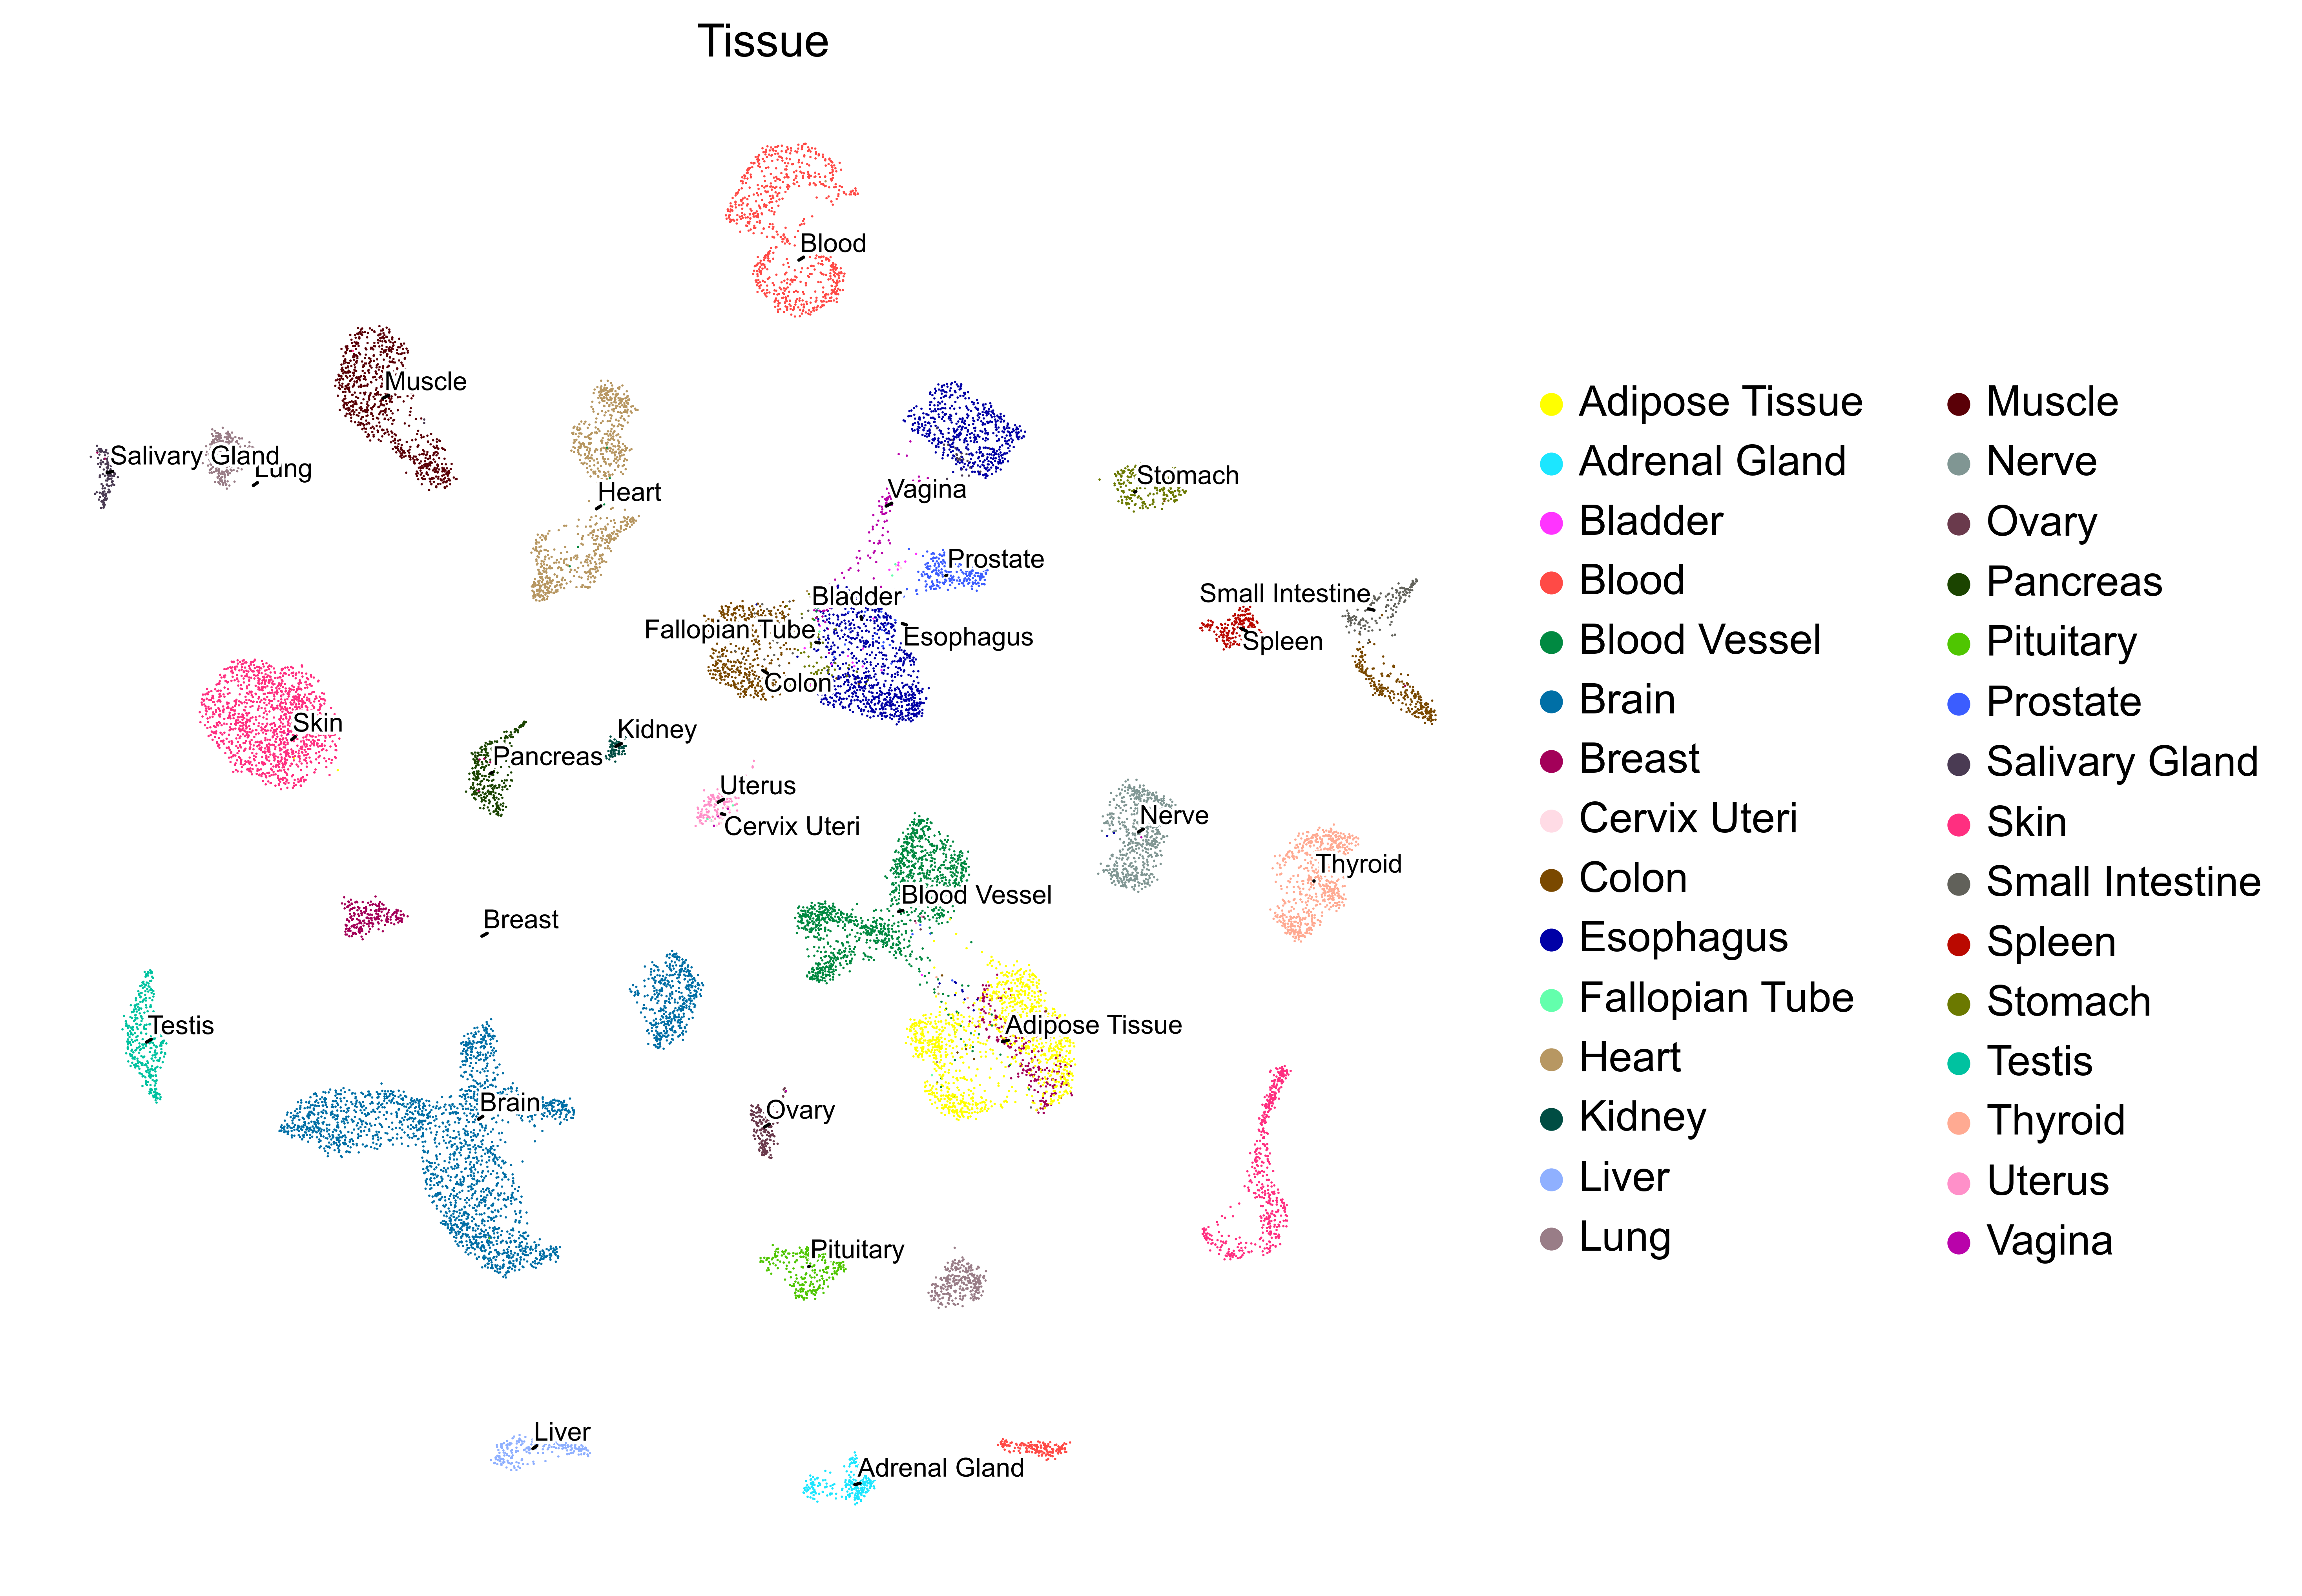

In [164]:
import matplotlib.patheffects as p

with plt.rc_context({"figure.figsize": (10, 7), "figure.dpi": 300, "figure.frameon": False, 'savefig.bbox': 'tight'}):
    #ax = sc.pl.umap(ads, color="Tissue", show=False, legend_loc=None, frameon=False, add_outline=False, outline_width=(0.1,0.1), size=2)
    ax = sc.pl.umap(ads, color="Tissue", show=False, frameon=False, add_outline=False, outline_width=(0.1,0.1), size=2)    
    pe = [p.withStroke(linewidth=2, foreground='w')]
    gen_mpl_labels(
        ads,
        "Tissue",
        exclude=("None", 'Unknown'),  # This was before we had the `nan` behaviour
        ax=ax,
        adjust_kwargs=dict(arrowprops=dict(arrowstyle='-', color='black')),
        text_kwargs=dict(fontsize=8, path_effects=pe),
    )
    fig = ax.get_figure()
    fig.tight_layout()
    plt.show()

In [224]:
ads.obs['Tissue detail'] = ads.obs['Tissue detail'].astype(str)

collapse = ['Adipose', 'Cervix', 'Kidney', 'Artery']
for c in collapse:
    ads.obs['Tissue detail'].loc[ads.obs['Tissue detail'].str.startswith(c)] = c
    
ads.obs['Tissue detail'].loc[ads.obs['Tissue detail'].isin(['Brain - Cerebellum', 'Brain - Cerebellar Hemisphere'])] = 'Brain - Cerebellum'
ads.obs['Tissue detail'].loc[ads.obs['Tissue detail'].str.startswith('Brain') & (ads.obs['Tissue detail']!='Brain - Cerebellum')] = 'Brain'

ads.obs['Tissue detail'].loc[ads.obs['Tissue detail'] == 'Breast'] = 'Breast - Mammary Tissue'
ads.obs['Tissue detail'].loc[ads.obs['Tissue detail'] == 'Esophagus mucosa'] = 'Esophagus - Mucosa'
ads.obs['Tissue detail'].loc[ads.obs['Tissue detail'] == 'Esophagus muscularis'] = 'Esophagus - Muscularis'
ads.obs['Tissue detail'].loc[ads.obs['Tissue detail'] == 'Skeletal muscle'] = 'Muscle - Skeletal'
ads.obs['Tissue detail'].loc[ads.obs['Tissue detail'] == 'Heart'] = 'Heart - Left Ventricle'
ads.obs['Tissue detail'].loc[ads.obs['Tissue detail'] == 'Skin'] = 'Skin - Sun Exposed (Lower leg)'

ads._sanitize()
del ads.uns['Tissue detail_colors']

/home/gokcen/.miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
... storing 'Tissue detail' as categorical


In [225]:
ads.obs

Sample ID          Tissue  \
GTEX-1117F-0226-SM-5GZZ7  GTEX-1117F-0226-SM-5GZZ7  Adipose Tissue   
GTEX-1117F-0426-SM-5EGHI  GTEX-1117F-0426-SM-5EGHI          Muscle   
GTEX-1117F-0526-SM-5EGHJ  GTEX-1117F-0526-SM-5EGHJ    Blood Vessel   
GTEX-1117F-0626-SM-5N9CS  GTEX-1117F-0626-SM-5N9CS    Blood Vessel   
GTEX-1117F-0726-SM-5GIEN  GTEX-1117F-0726-SM-5GIEN           Heart   
...                                            ...             ...   
skin_CST_GTEX-15EOM       GTEX-15EOM-5003-SM-G64IH            Skin   
skin_EZ_GTEX-15EOM        GTEX-15EOM-5003-SM-G64IH            Skin   
skin_NST_GTEX-1HSMQ       GTEX-1HSMQ-5007-SM-GKSJG            Skin   
skin_NST_GTEX-15EOM       GTEX-15EOM-5003-SM-G64IH            Skin   
skin_TST_GTEX-1HSMQ       GTEX-1HSMQ-5007-SM-GKSJG            Skin   

                                           Tissue detail Participant ID  prep  \
GTEX-1117F-0226-SM-5GZZ7                         Adipose     GTEX-1117F  bulk   
GTEX-1117F-0426-SM-5EGHI               Muscle - Skeletal     GTEX-1117F  bulk   
GTEX-1117F-0526-SM-5EGHJ                          Artery     GTEX-1117F  bulk   
GTEX-1117F-0626-SM-5N9CS                          Artery     GTEX-1117F  bulk   
GTEX-1117F-0726-SM-5GIEN        Heart - Atrial Appendage     GTEX-1117F  bulk   
...                                                  ...            ...   ...   
skin_CST_GTEX-15EOM       Skin - Sun Exposed (Lower leg)     GTEX-15EOM   CST   
skin_EZ_GTEX-15EOM        Skin - Sun Exposed (Lower leg)     GTEX-15EOM    EZ   
skin_NST_GTEX-1HSMQ       Skin - Sun Exposed (Lower leg)     GTEX-1HSMQ   NST   
skin_NST_GTEX-15EOM       Skin - Sun Exposed (Lower leg)     GTEX-15EOM   NST   
skin_TST_GTEX-1HSMQ       Skin - Sun Exposed (Lower leg)     GTEX-1HSMQ   TST   

                         bulk-pseudobulk Tissue_with_sn_labels  \
GTEX-1117F-0226-SM-5GZZ7            bulk                  bulk   
GTEX-1117F-0426-SM-5EGHI            bulk                  bulk   
GTEX-1117F-0526-SM-5EGHJ            bulk                  bulk   
GTEX-1117F-0626-SM-5N9CS            bulk                  bulk   
GTEX-1117F-0726-SM-5GIEN            bulk                  bulk   
...                                  ...                   ...   
skin_CST_GTEX-15EOM           pseudobulk                  Skin   
skin_EZ_GTEX-15EOM            pseudobulk                  Skin   
skin_NST_GTEX-1HSMQ           pseudobulk                  Skin   
skin_NST_GTEX-15EOM           pseudobulk                  Skin   
skin_TST_GTEX-1HSMQ           pseudobulk                  Skin   

                            bulk_pseudobulk  
GTEX-1117F-0226-SM-5GZZ7               Bulk  
GTEX-1117F-0426-SM-5EGHI               Bulk  
GTEX-1117F-0526-SM-5EGHJ               Bulk  
GTEX-1117F-0626-SM-5N9CS               Bulk  
GTEX-1117F-0726-SM-5GIEN               Bulk  
...                                     ...  
skin_CST_GTEX-15EOM       Pseudobulk (Skin)  
skin_EZ_GTEX-15EOM        Pseudobulk (Skin)  
skin_NST_GTEX-1HSMQ       Pseudobulk (Skin)  
skin_NST_GTEX-15EOM       Pseudobulk (Skin)  
skin_TST_GTEX-1HSMQ       Pseudobulk (Skin)  

[17472 rows x 8 columns]

In [254]:
pd.options.display.max_columns = None

<ipython-input-226-234b9985d8d6>:15: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


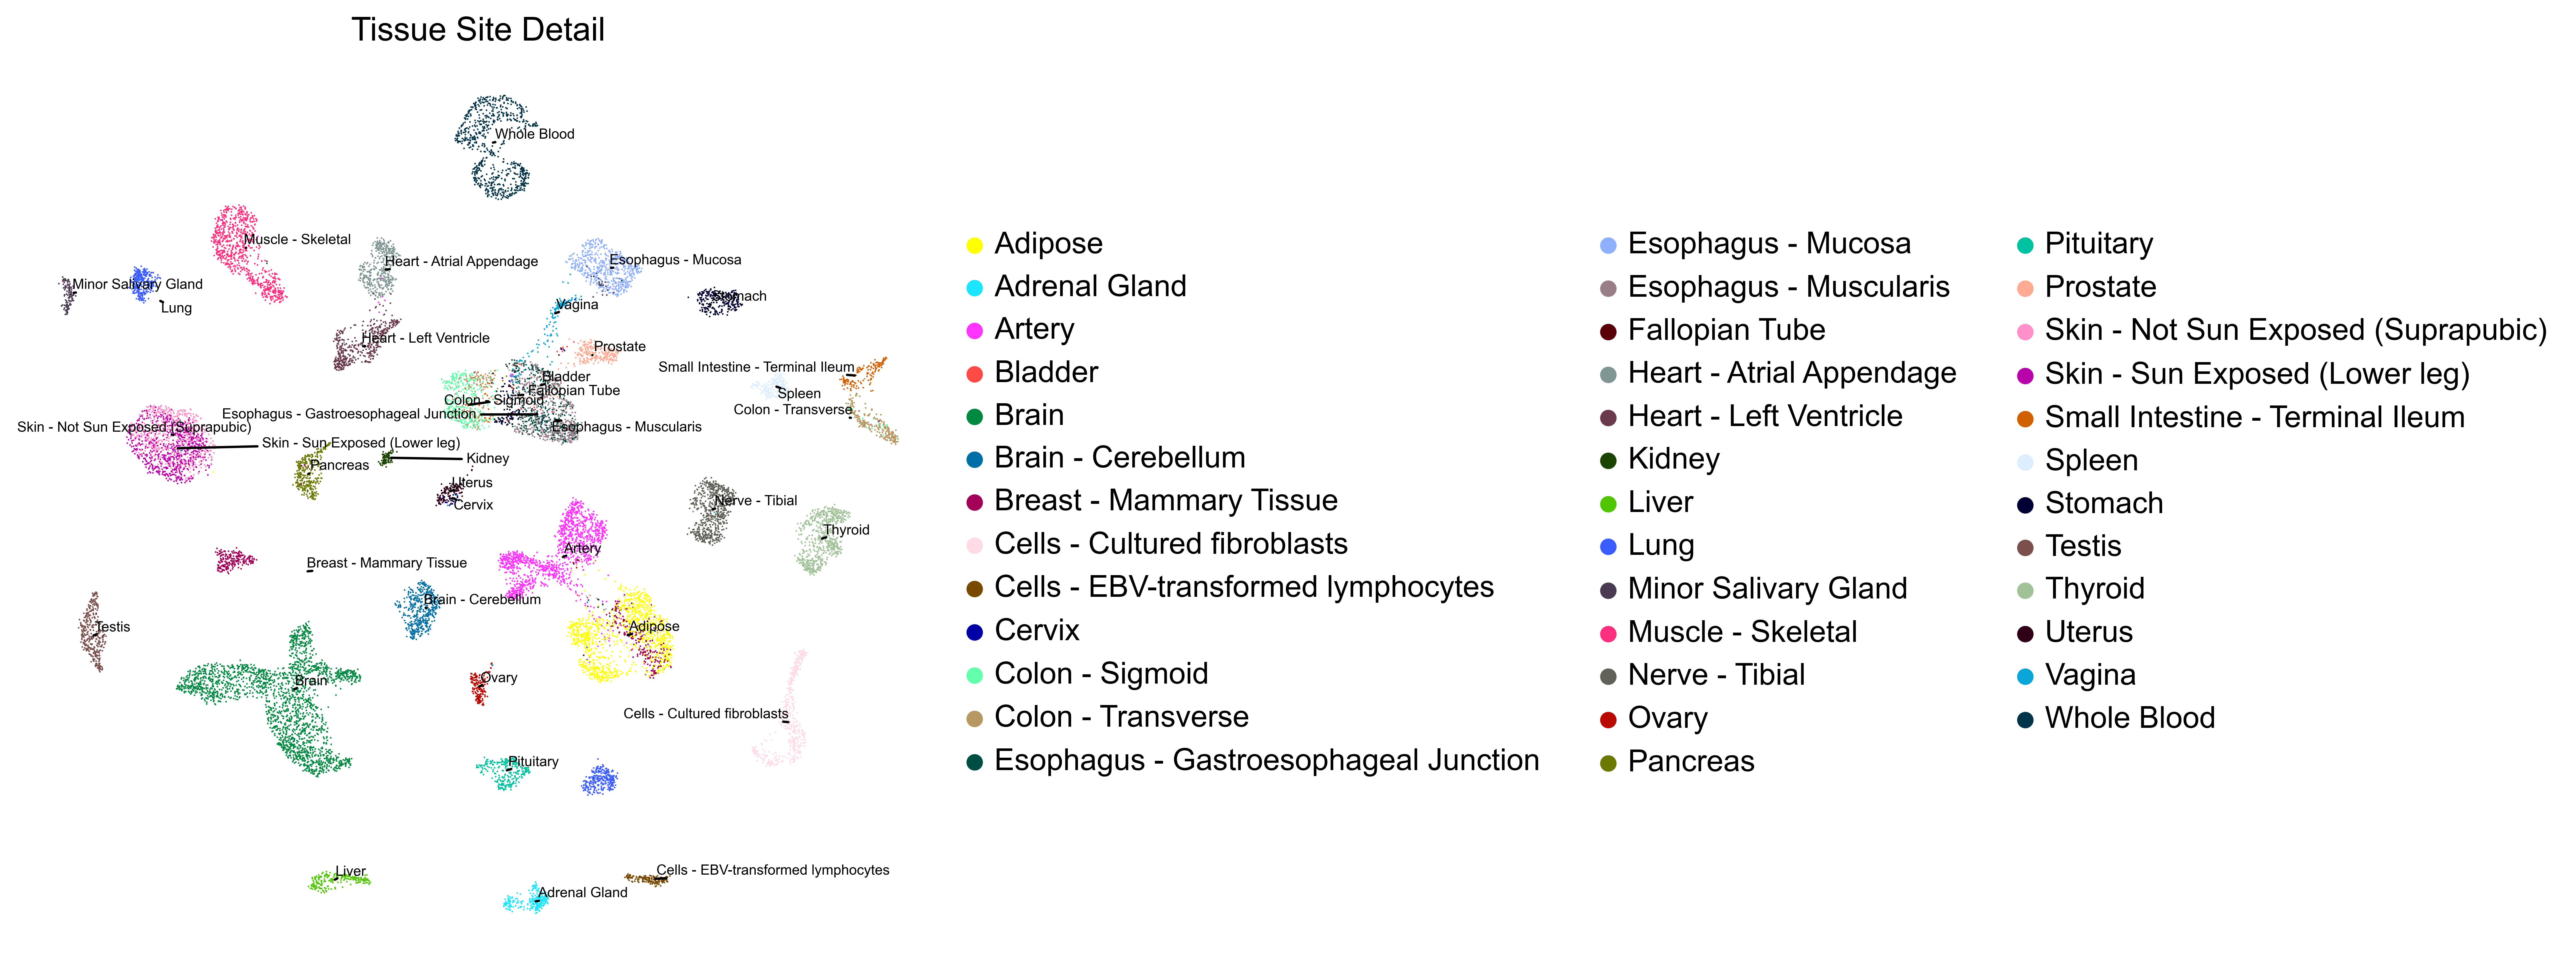

In [226]:
import matplotlib.patheffects as p

with plt.rc_context({"figure.figsize": (7, 7), "figure.dpi": 300, "figure.frameon": False, 'savefig.bbox': 'tight'}):
    ax = sc.pl.umap(ads, color="Tissue detail", show=False, frameon=False, add_outline=False, outline_width=(0.1,0.1), size=2, title='Tissue Site Detail')    
    pe = [] #[p.withStroke(linewidth=2, foreground='w')]
    gen_mpl_labels(
        ads,
        "Tissue detail",
        exclude=("None", 'Unknown'),  # This was before we had the `nan` behaviour
        ax=ax,
        adjust_kwargs=dict(arrowprops=dict(arrowstyle='-', color='black')),
        text_kwargs=dict(fontsize=6, path_effects=pe),
    )
    fig = ax.get_figure()
    fig.tight_layout()
    plt.show()

In [169]:
sc.settings.figdir = './'

In [215]:
ads.obs['bulk_pseudobulk'] = ads.obs['Tissue_with_sn_labels'].astype(str)

In [220]:
data = pd.concat([pd.DataFrame(ads.obsm['X_umap'], columns=['umap1', 'umap2'], index=ads.obs_names), ads.obs], axis=1)
data.head()

umap1      umap2                 Sample ID  \
GTEX-1117F-0226-SM-5GZZ7  13.269734   4.732814  GTEX-1117F-0226-SM-5GZZ7   
GTEX-1117F-0426-SM-5EGHI  -3.039704  21.636843  GTEX-1117F-0426-SM-5EGHI   
GTEX-1117F-0526-SM-5EGHJ  10.448679   7.955308  GTEX-1117F-0526-SM-5EGHJ   
GTEX-1117F-0626-SM-5N9CS  10.504798   6.021122  GTEX-1117F-0626-SM-5N9CS   
GTEX-1117F-0726-SM-5GIEN   2.901899  19.261417  GTEX-1117F-0726-SM-5GIEN   

                                  Tissue             Tissue detail  \
GTEX-1117F-0226-SM-5GZZ7  Adipose Tissue    Adipose - Subcutaneous   
GTEX-1117F-0426-SM-5EGHI          Muscle         Muscle - Skeletal   
GTEX-1117F-0526-SM-5EGHJ    Blood Vessel           Artery - Tibial   
GTEX-1117F-0626-SM-5N9CS    Blood Vessel         Artery - Coronary   
GTEX-1117F-0726-SM-5GIEN           Heart  Heart - Atrial Appendage   

                         Participant ID  prep bulk-pseudobulk  \
GTEX-1117F-0226-SM-5GZZ7     GTEX-1117F  bulk            bulk   
GTEX-1117F-0426-SM-5EGHI     GTEX-1117F  bulk            bulk   
GTEX-1117F-0526-SM-5EGHJ     GTEX-1117F  bulk            bulk   
GTEX-1117F-0626-SM-5N9CS     GTEX-1117F  bulk            bulk   
GTEX-1117F-0726-SM-5GIEN     GTEX-1117F  bulk            bulk   

                         Tissue_with_sn_labels bulk_pseudobulk  
GTEX-1117F-0226-SM-5GZZ7                  bulk            Bulk  
GTEX-1117F-0426-SM-5EGHI                  bulk            Bulk  
GTEX-1117F-0526-SM-5EGHJ                  bulk            Bulk  
GTEX-1117F-0626-SM-5N9CS                  bulk            Bulk  
GTEX-1117F-0726-SM-5GIEN                  bulk            Bulk

/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6 x 6 in image.
/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: Figure-S1-8B.pdf
/home/gokcen/.miniconda3/lib/python3.8/site-packages/mizani/palettes.py:397: UserWarning: Warning message:Brewer palette Set2 has a maximum of 8 colors Returning the palette you asked for with that many colors
/home/gokcen/.miniconda3/lib/python3.8/site-packages/mizani/palettes.py:397: UserWarning: Warning message:Brewer palette Set2 has a maximum of 8 colors Returning the palette you asked for with that many colors
/home/gokcen/.miniconda3/lib/python3.8/site-packages/mizani/palettes.py:397: UserWarning: Warning message:Brewer palette Set2 has a maximum of 8 colors Returning the palette you asked for with that many colors
/home/gokcen/.miniconda3/lib/python3.8/site-packages/mizani/palettes.py:397: UserWarning: Warning message:Brewer palette Set2 has a 

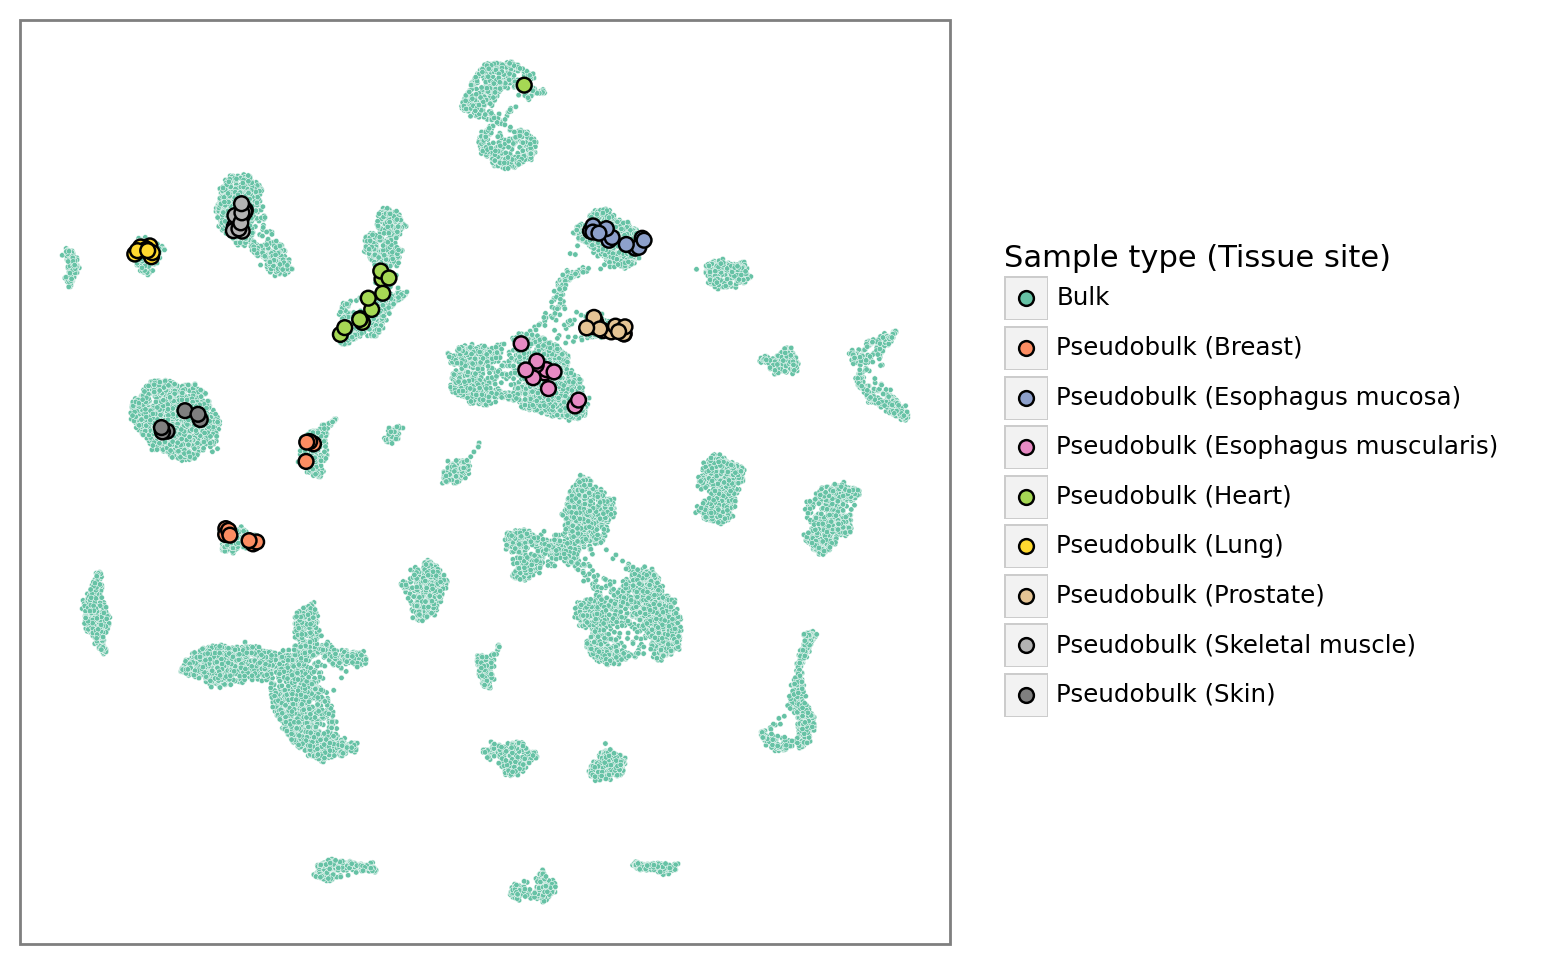

<ggplot: (8735213252886)>

In [222]:
from plotnine import *

g = (
    ggplot(aes(x='umap1', y='umap2', fill='bulk_pseudobulk'), data=data) + 
    geom_point(data=data[data['bulk-pseudobulk']=='bulk'], color='white', stroke=0.1, size=1) + 
    geom_point(data=data[data['bulk-pseudobulk']!='bulk'], size=2.5) +    
    scale_fill_brewer(type='qual', palette='Set2') +
    labs(x='', y='', fill='Sample type (Tissue site)') + 
    theme_bw() +
    theme(figure_size=(6,6), panel_grid=element_blank(), axis_text_x=element_blank(), axis_text_y=element_blank(), axis_ticks_major=element_blank(), axis_ticks_minor=element_blank())
)

g

## Plot the results

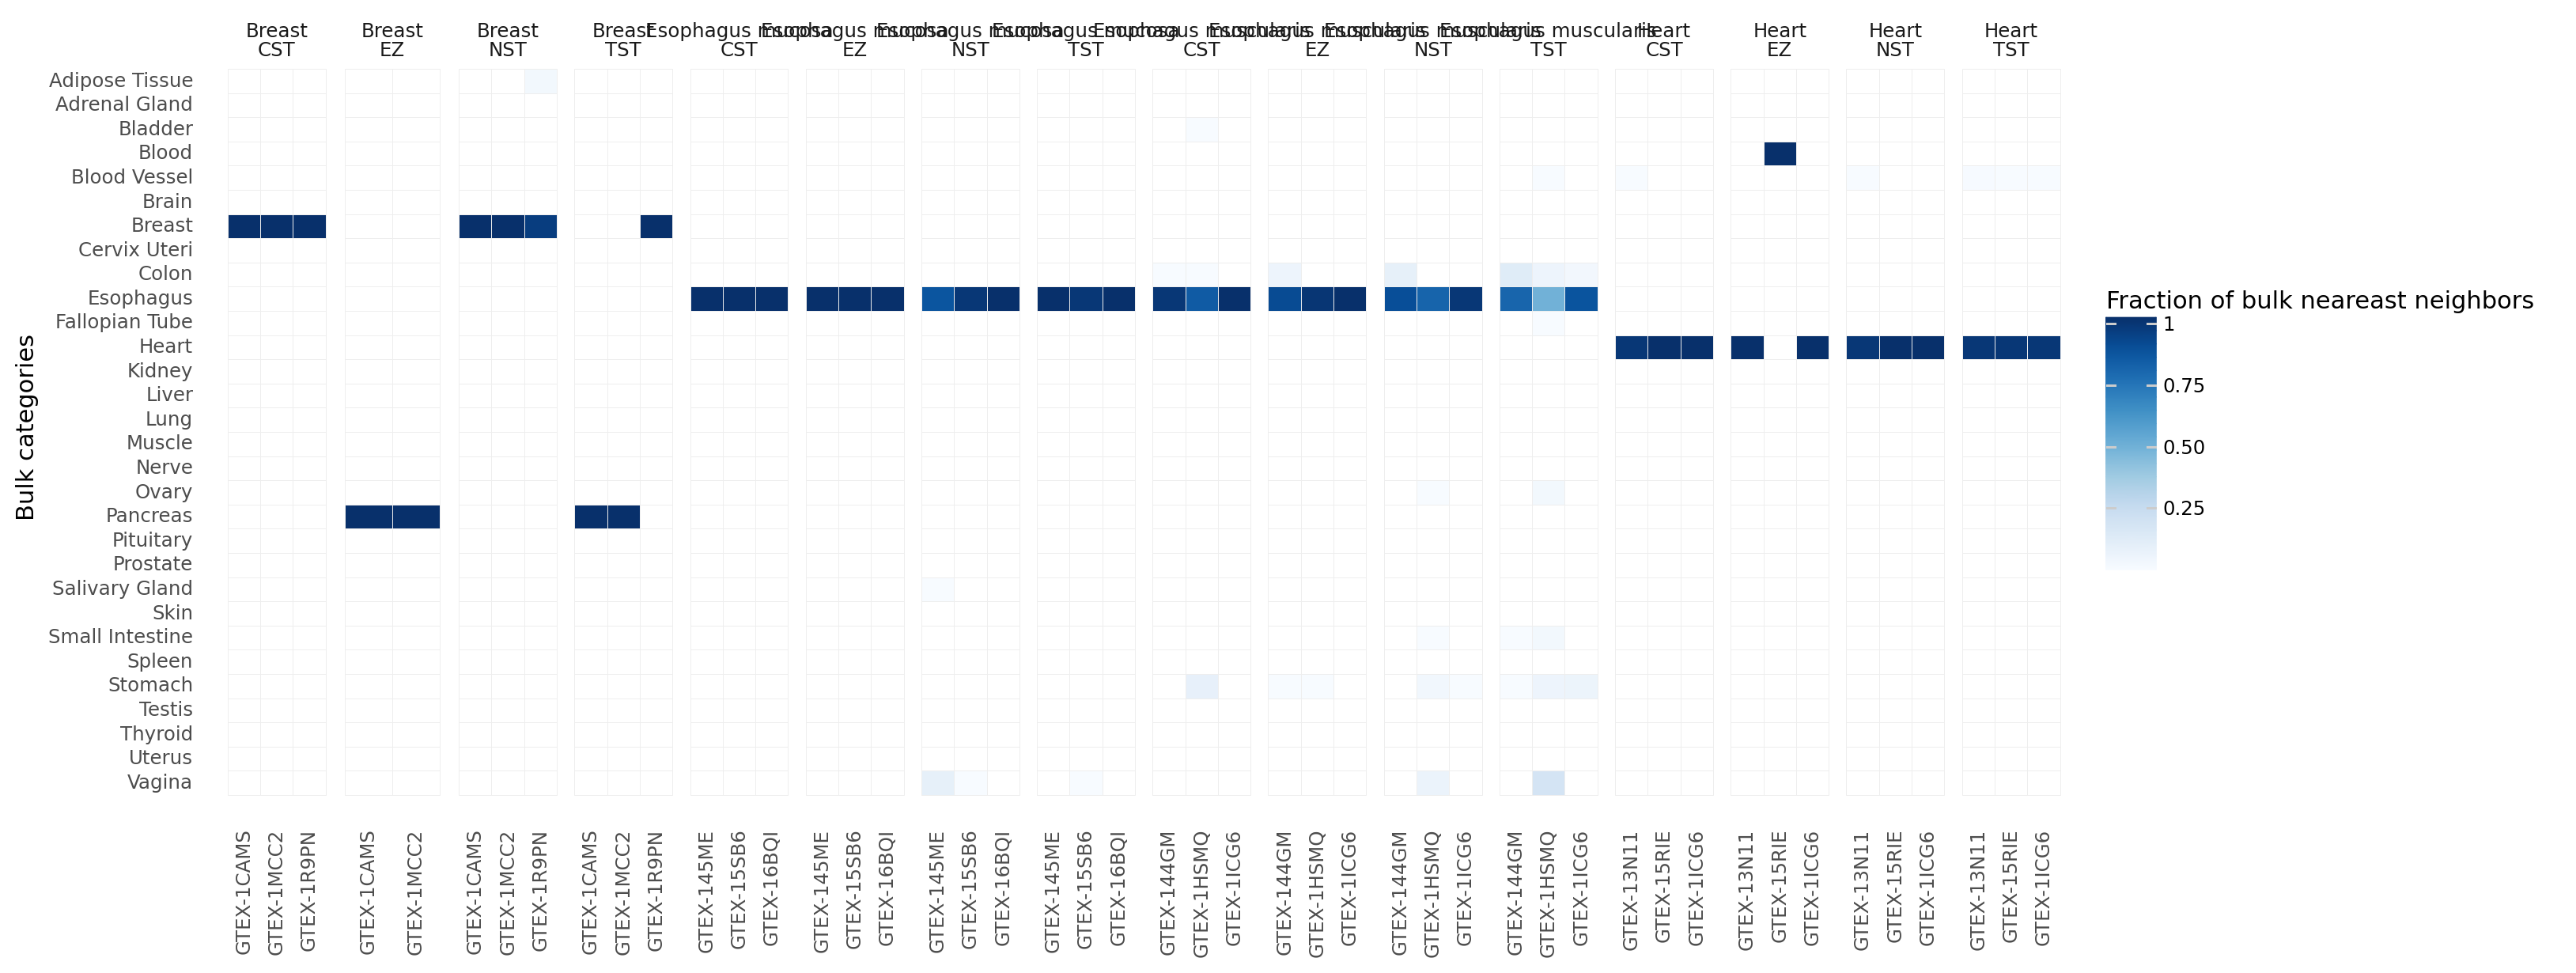

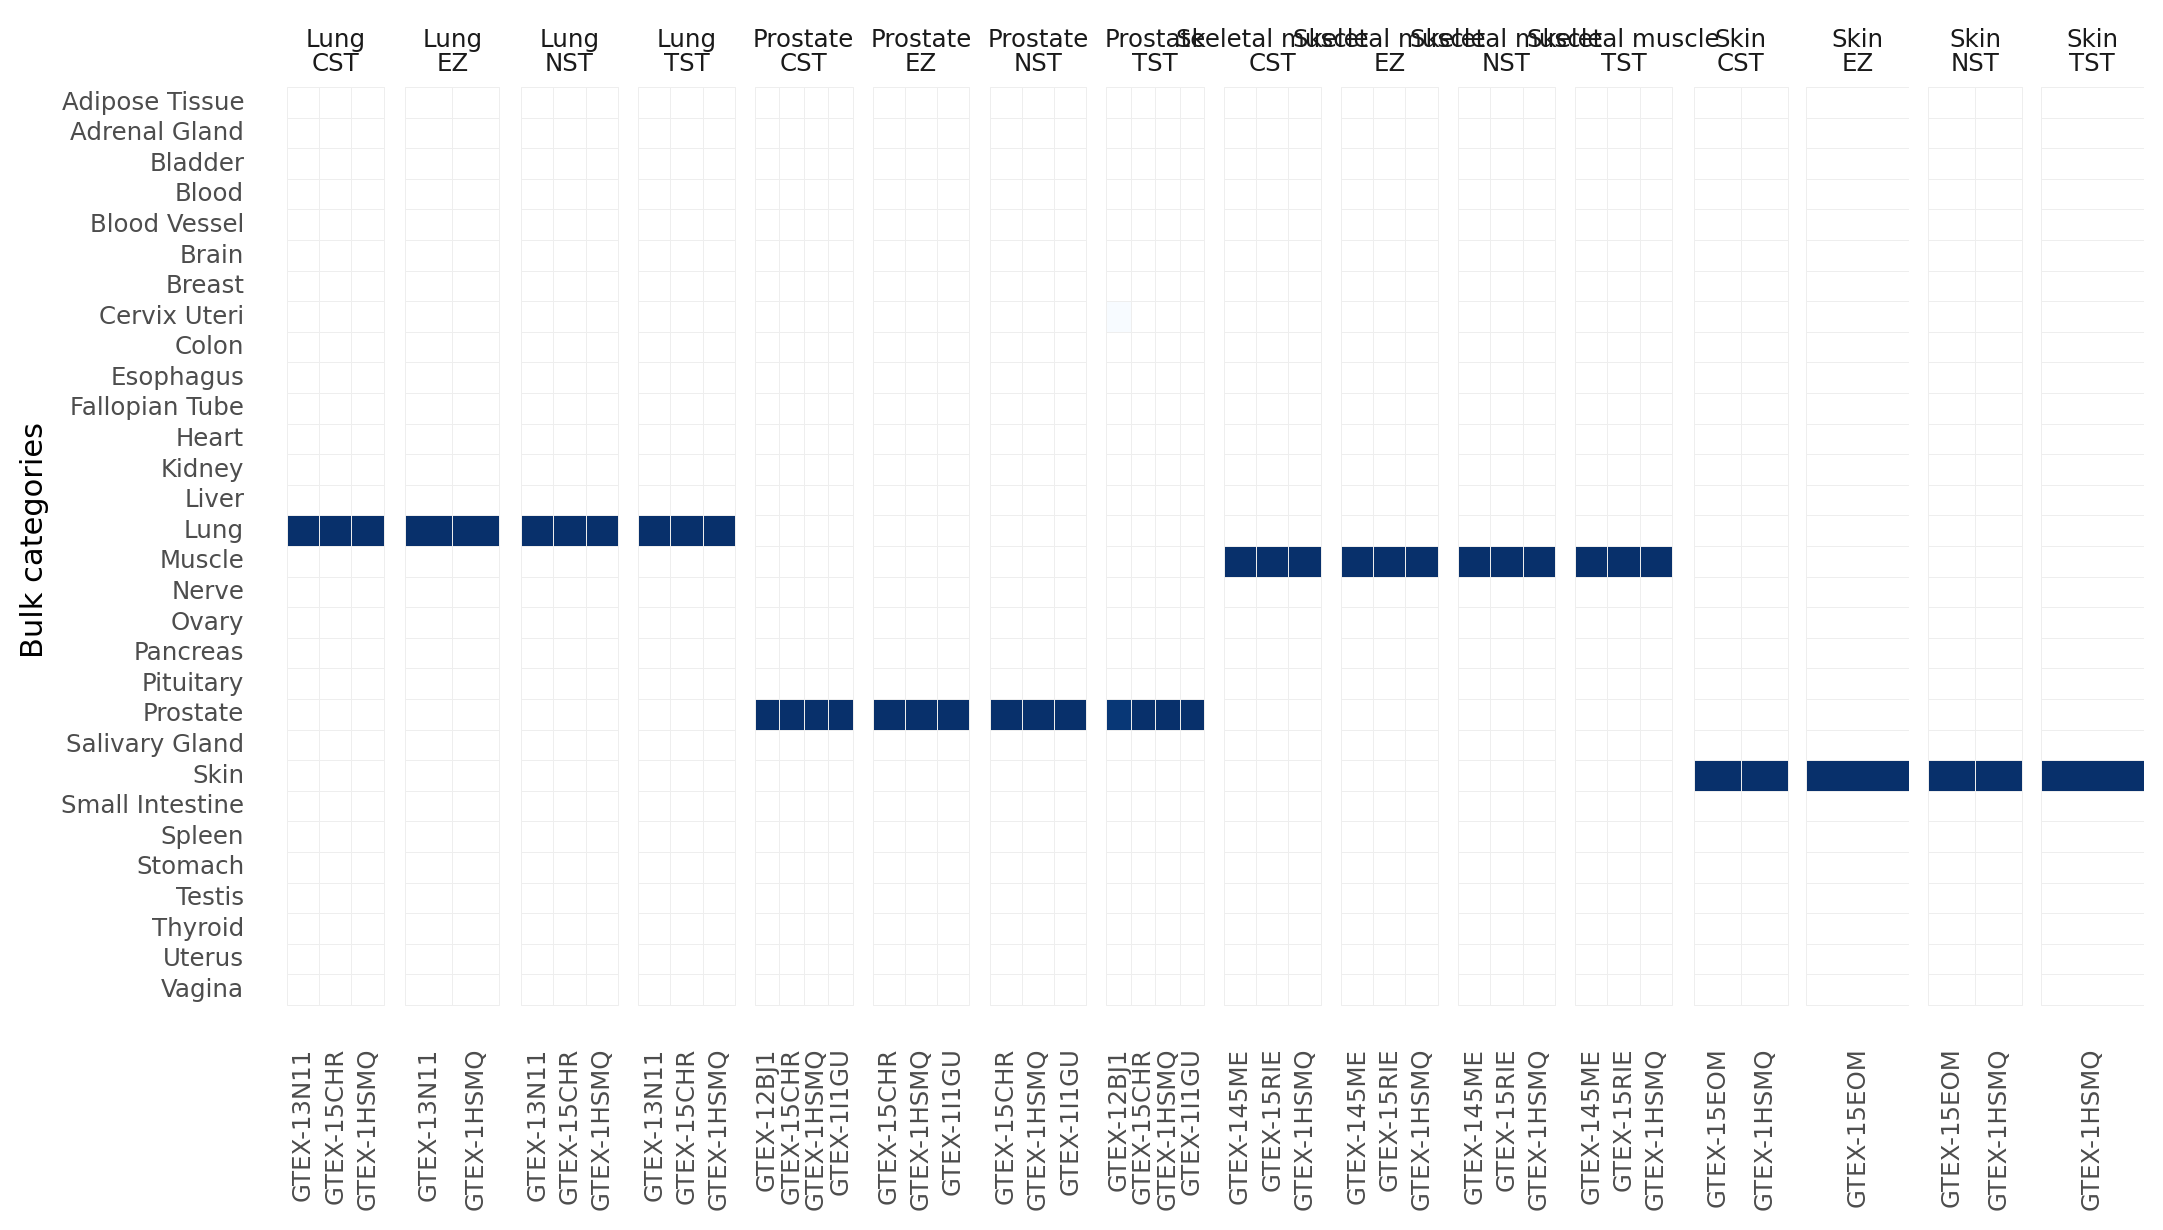

In [28]:
from plotnine import *

g1 = (
    ggplot(aes(x='sample', y='index'), data=props[props.orig_tissue.isin(['Breast', 'Esophagus mucosa', 'Esophagus muscularis', 'Heart'])]) + 
    geom_tile(aes(fill='Tissue'), color='#eeeeee', size=0.2) + 
    facet_grid('~orig_tissue+prep', scales='free_x') + 
    scale_fill_cmap('Blues', na_value='white') + 
    scale_x_discrete(labels=lambda x: [i.split("_")[2] for i in x.keys()]) + 
    theme_minimal() +
    theme(figure_size=(15, 6), axis_text_x=element_text(angle=90), panel_grid=element_blank()) + 
    labs(y='Bulk categories', x='', fill='Fraction of bulk neareast neighbors')
)

g2 = (
    ggplot(aes(x='sample', y='index'), data=props[props.orig_tissue.isin(['Lung', 'Prostate', 'Skeletal muscle', 'Skin'])]) + 
    geom_tile(aes(fill='Tissue'), color='#eeeeee', size=0.2) + 
    facet_grid('~orig_tissue+prep', scales='free_x') + 
    scale_fill_cmap('Blues', na_value='white') + 
    scale_x_discrete(labels=lambda x: [i.split("_")[2] for i in x.keys()]) + 
    theme_minimal() +
    guides(fill=False) + 
    theme(figure_size=(12, 6), axis_text_x=element_text(angle=90), panel_grid=element_blank()) + 
    labs(y='Bulk categories', x='', fill='Fraction of bulk neareast neighbors')
)

print(g1)
print(g2)